In [1]:
import os
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch.nn as nn
from tqdm.auto import tqdm

import multitask.dataset as dataset
from multitask.models.task_switching import get_task_model, calculate_rdm, plot_rdm
import multitask.models.task_switching.hooks as hooks
from multitask.utils.training import get_device
from multitask.utils.argparse import check_runs

In [2]:
sns.set_theme(style='ticks', palette='pastel')
mpl.rcParams['font.family'] = 'Liberation Sans'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [3]:
path_data = os.path.join('..', '..', 'data')
path_figure_accuracy = os.path.join('svg', 'figure06d_context_strength.svg')
path_figure_rdm = os.path.join('svg', 'figure06d_rdm.svg')
path_model_task_switching = os.path.join('..', '..', 'results', 'task_switching')

In [4]:
num_runs = 10
initial_seed = 6789
max_seed = 10e5
num_epochs = 50
num_hidden = 10 * [100]
batch_size = 100
num_train = 50000
num_test = 10000
tasks_names = ['parity', 'value']
# tasks_names = ["parity", "small", "prime", "fibonacci", "multiples_3"]
idxs_contexts = list(range(len(num_hidden)))

In [5]:
parameters = {
    'num_runs': num_runs,
    'initial_seed': initial_seed,
    'max_seed': max_seed,
    'num_epochs': num_epochs,
    'num_hidden': num_hidden,
    'batch_size': batch_size,
    'num_train': num_train,
    'num_test': num_test,
    'tasks': tasks_names,
    'idxs_contexts': idxs_contexts
}

data_folder = check_runs(path_model_task_switching, parameters)

Found simulation in ../../results/task_switching with the same parameters (2022-09-28_02_23_14)


In [6]:
pickle_data = os.path.join(data_folder, 'data.pickle')
with open(pickle_data, 'rb') as handle:
    results_task_switching = pickle.load(handle)

In [7]:
seeds = sorted(list(results_task_switching.keys()))
num_seeds = len(seeds)
num_tasks = len(tasks_names)

print(seeds)
print(tasks_names)

[10612, 17350, 130146, 173249, 213794, 341996, 440064, 668870, 858781, 894813]
['parity', 'value']


In [8]:
tasks_datasets = dataset.get_tasks_dict(tasks_names, root=path_data)

task_switching_tasks = {}
num_tasks = len(tasks_names)

for task_name in tasks_names:
    task_switching_tasks[task_name] = {}
    task_switching_tasks[task_name]['data'] = tasks_datasets[task_name]
    task_switching_tasks[task_name]['activations'] = num_tasks * [0]

for key, value in task_switching_tasks.items():
    print(f'{key}: {value["activations"]}')

/home/sgalella/miniconda3/envs/multitask/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-ex__3qls/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


parity: [0, 0]
value: [0, 0]


In [9]:
if num_tasks > 2:
    raise NotImplementedError

task_name_A, task_name_B = tasks_names

In [10]:
device = get_device()
criterion = nn.CrossEntropyLoss()

Running on GPU.


In [11]:
contexts = np.linspace(1, 30, 101)

num_layers = len(num_hidden)
num_contexts = len(contexts)

accuracy_matrix = np.zeros((num_seeds, num_tasks, num_contexts))
list_rdm = []


for i_context, context in tqdm(enumerate(contexts), total=len(contexts)):

    task_switching_tasks[task_name_A]['activations'] = num_tasks * [0]
    task_switching_tasks[task_name_B]['activations'] = num_tasks * [0]

    task_switching_tasks[task_name_A]['activations'][0] = context
    task_switching_tasks[task_name_A]['activations'][1] = 0

    task_switching_tasks[task_name_B]['activations'][0] = 0
    task_switching_tasks[task_name_B]['activations'][1] = context

    if i_context == 0 or i_context == num_contexts - 1 or i_context == num_contexts // 2:
        list_rdm.append([])


    for i_seed, seed in enumerate(seeds):
        state_dict = results_task_switching[seed]['model']
        model = get_task_model(task_switching_tasks,
                            num_hidden,
                            idxs_contexts,
                            device)
        model.load_state_dict(state_dict)
        
        indices = results_task_switching[seed]['indices']

        test_sampler = dataset.SequentialSampler(indices['test'])
        _, test_dataloaders = dataset.create_dict_dataloaders(task_switching_tasks,
                                                            indices,
                                                            batch_size=batch_size)
        tasks_testloader = dataset.SequentialTaskDataloader(test_dataloaders)

        numbers = test_dataloaders[tasks_names[0]].dataset.numbers.numpy()
        numbers = numbers[indices['test']]

        acc_test, activations = hooks.get_layer_activations(model,
                                                            tasks_testloader,
                                                            criterion,
                                                            device=device,
                                                            disable=True)

        accuracy_matrix[i_seed, 0, i_context] = acc_test[task_name_A].mean()
        accuracy_matrix[i_seed, 1, i_context]= acc_test[task_name_B].mean()

        if i_context == 0 or i_context == num_contexts - 1 or i_context == num_contexts // 2:
            rdm_dict = calculate_rdm(activations,
                                    task_switching_tasks,
                                    num_hidden,
                                    numbers)
            list_rdm[-1].append(rdm_dict)

100%|██████████| 101/101 [08:24<00:00,  4.99s/it]


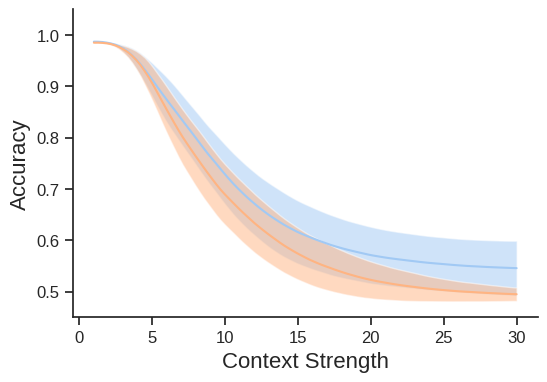

In [12]:
mean_tasks = accuracy_matrix.mean(axis=0)
std_tasks = accuracy_matrix.std(axis=0)

mean_task_A = mean_tasks[0, :]
mean_task_B = mean_tasks[1, :]

std_task_A = std_tasks[0, :]
std_task_B = std_tasks[1, :]


fig = plt.figure(figsize=(6, 4))

plt.plot(contexts, mean_task_A)
plt.fill_between(contexts,
                 mean_task_A-std_task_A,
                 mean_task_A+std_task_A,
                 alpha=0.5)

plt.plot(contexts, mean_task_B)
plt.fill_between(contexts,
                 mean_task_B-std_task_B,
                 mean_task_B+std_task_B,
                 alpha=0.5)

plt.ylim(.45, 1.05)
# plt.legend([task_name_A.capitalize(), task_name_B.capitalize()], prop={'size':14}, loc='best')
# plt.legend([task_name_A.capitalize(), 'Value'], prop={'size':14}, loc='best')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('Context Strength', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)

fig.savefig(path_figure_accuracy)
plt.show()

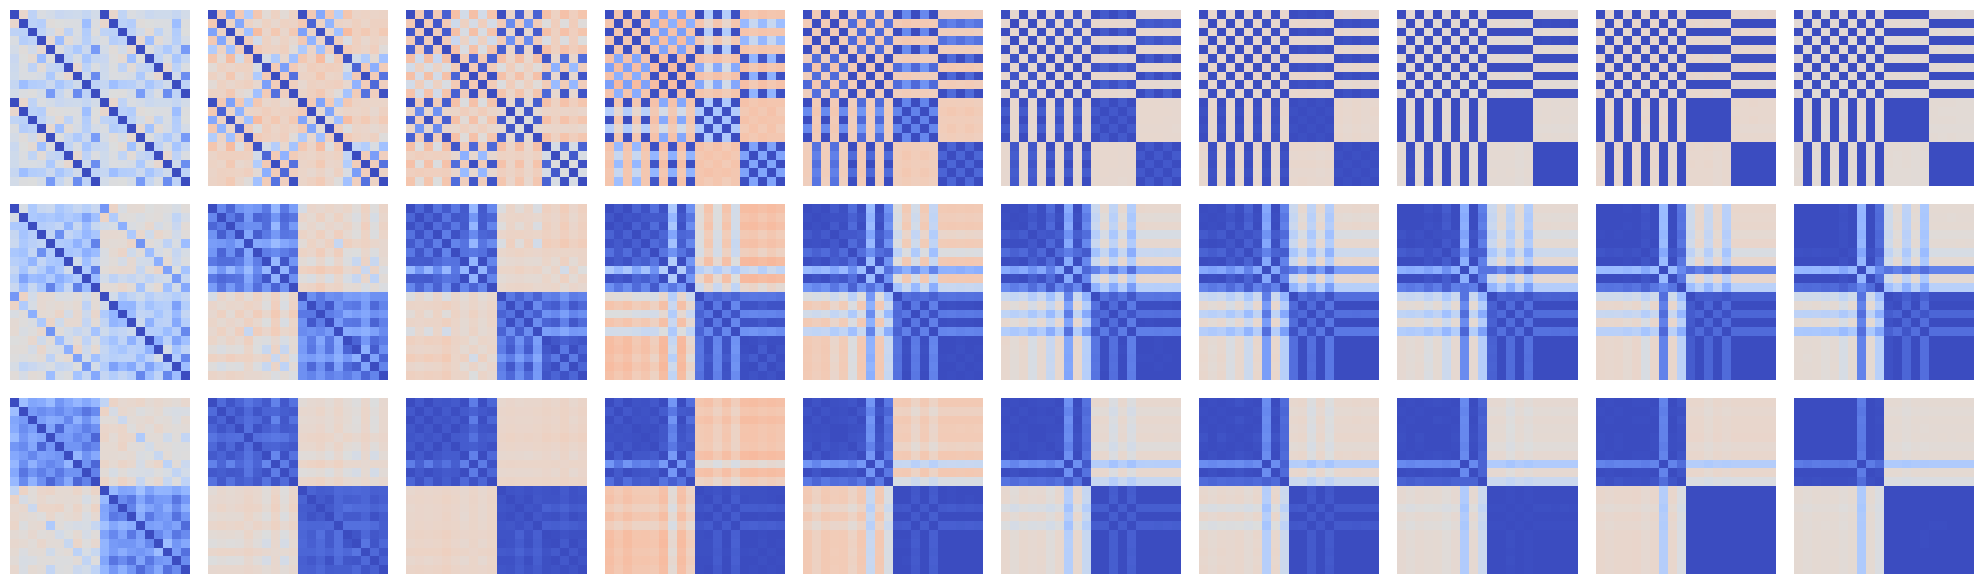

In [13]:
num_rdm = len(list_rdm)

fig, ax = plt.subplots(num_rdm, num_layers, figsize=(2 * num_layers, 2 * num_rdm))

for i_context, context_rdm in enumerate(list_rdm):
    mean_rdm = {}
    for layer in range(num_layers):
        mean_rdm[layer+1] = np.zeros((num_tasks * 10, num_tasks * 10))
        for rdm in context_rdm:
            mean_rdm[layer+1] += rdm[layer+1]
        mean_rdm[layer+1] /= num_runs

    plot_rdm(ax[i_context], mean_rdm, num_hidden, idxs_contexts, cmap='coolwarm', vmin=0, vmax=1)

fig.tight_layout()
fig.savefig(path_figure_rdm)
plt.show()